## Prepare imports

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import pyvista as pv
from torch_geometric.data import Batch
import pyvista as pv
pv.set_jupyter_backend("static")

from models.encoder import BaseModel as Encoder
from models.vae import BaseModel as VAE

from load_configs import load_config

import matplotlib.pyplot as plt

DEVICE = "cuda:0"

from datasets import load_datamodule

from models.encoder import BaseModel as Encoder


encoder_config = load_config("./configs/config_encoder_topological.yaml")
dm = load_datamodule(encoder_config.data)


encoder = Encoder.load_from_checkpoint(f"./trained_models/{encoder_config.modelconfig.save_name}").to(DEVICE)
vae = VAE.load_from_checkpoint("./trained_models/vae_topological.ckpt")



C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.3


## Load Models and Data

In [2]:
# batch_len = len(dm.test_dataloader())
test_ds = dm.test_ds

# For each class, grab 16 samples.
mfld_classes = test_ds.y.unique() 

test_data_list = []

for idx in mfld_classes: 
    test_data_list.extend([test_ds[test_ds.y == idx][i] for i in range(1)])


test_batch = Batch.from_data_list(test_data_list).to(DEVICE)
points_batch = test_batch.x.cpu().detach().view(-1,1024,3).numpy()


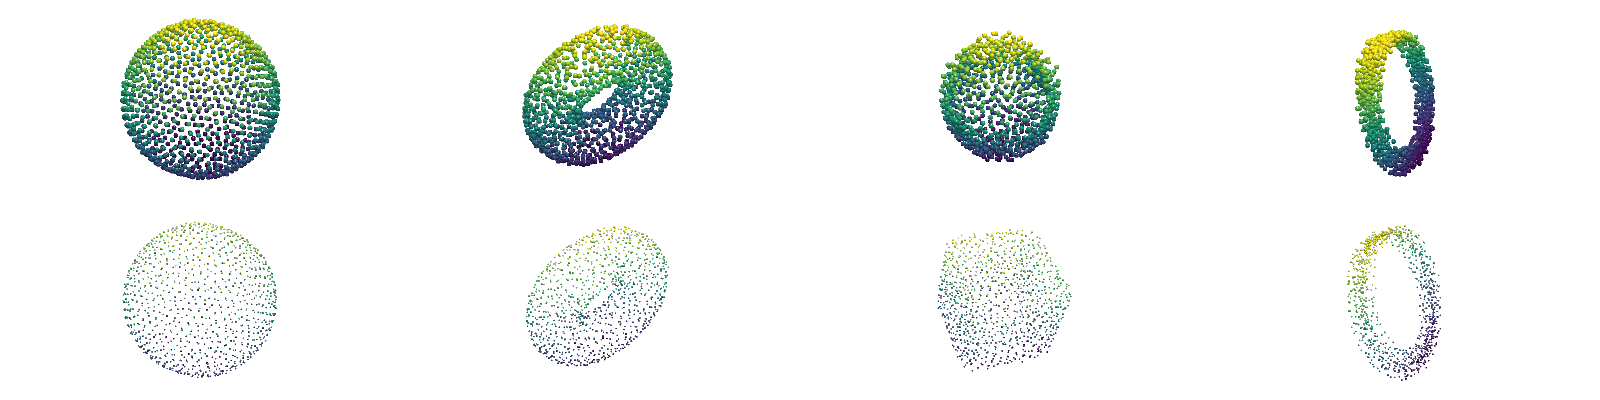

In [3]:

ect = encoder.layer(test_batch,test_batch.batch).unsqueeze(1)


with torch.no_grad():
    recon_pts = encoder(ect)
    recon_ect_vae, _, _, _ = vae(2*ect-1)

# Undo the VAE transform
recon_ect_vae = (recon_ect_vae + 1 ) / 2

with torch.no_grad():
    recon_vae_pts = encoder.model(recon_ect_vae).cpu().detach().numpy()


pl = pv.Plotter(shape=(2, 4), window_size=[1600, 400],border=False,polygon_smoothing=True)


for idx in range(4):
    points_vae = recon_vae_pts[idx].reshape(-1, 3)
    pl.subplot(0, idx)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )

    points = recon_pts[idx].reshape(-1, 3).cpu().detach().numpy()
    pl.subplot(1, idx)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=2,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/topological/reconstructed_pointcloud.png",transparent_background=True,scale=2)
pl.show()



# Latent space

In [4]:
# Get all validation samples.
import pandas as pd 

ys = []
zs = []
mfld = []
with torch.no_grad():
    for batch in dm.val_dataloader():
        batch.cuda()
        ect_val = 2*vae.layer(batch,batch.batch) -1 
        mu, log_var = vae.model.encode(ect_val.unsqueeze(1))
        z = vae.model.reparameterize(mu, log_var)
        recon_ect = (vae.model.decode(z)+1)/2
        ys.append(batch.y)
        zs.append(mu)
        mfld.append(batch.x.view(-1,1024,3))

    ys = torch.hstack(ys)
    zs = torch.vstack(zs)
    mfld = torch.vstack(mfld).cpu().numpy()


zs.shape

torch.Size([12000, 64])

In [5]:
import seaborn as sns 

df = pd.DataFrame(zs.to(dtype=torch.float16).cpu().detach().numpy())
df["label"] = ys.cpu().to(dtype=int)

In [6]:
import umap 
from sklearn.preprocessing import StandardScaler

C:\Users\ernst\AppData\Local\Temp\ipykernel_22788\317775273.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


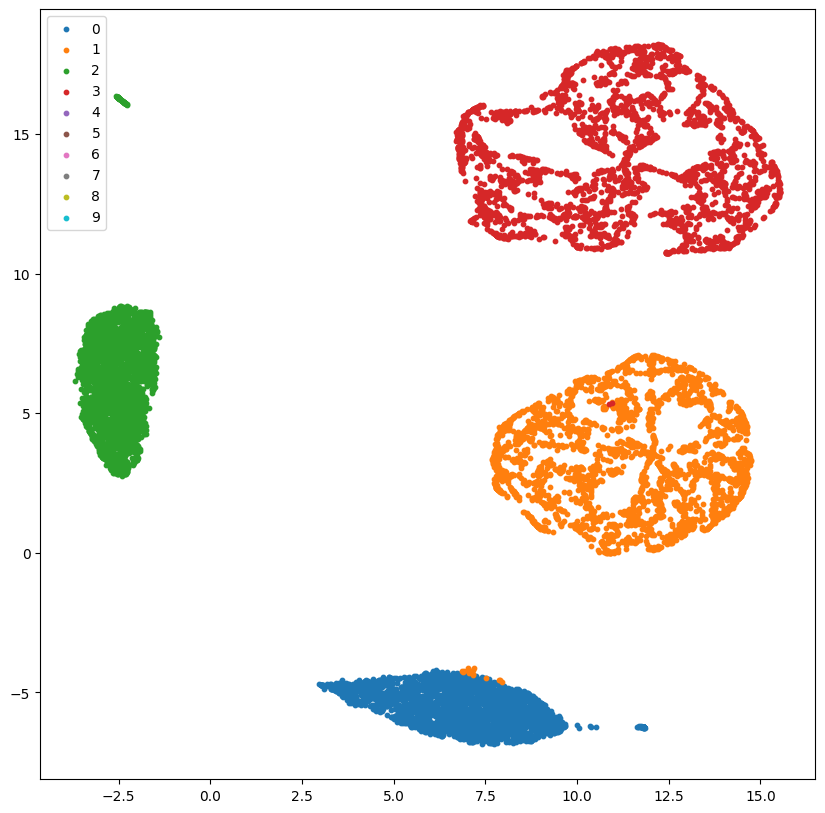

In [7]:
reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.1,
        n_components=2,
        metric="euclidean"
    )
embedding = reducer.fit_transform(df[[i for i in range(64)]])

fig, ax = plt.subplots(figsize=(10,10))

for label in range(10):
    idx = df["label"] == label
    ax.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        s=10,
        c=sns.color_palette()[label],label=str(label))
ax.legend()
    # plt.gca().set_aspect('equal', 'datalim')
    # plt.title('UMAP projection', fontsize=24);
    # plt.legend()


In [8]:
from io import BytesIO
from PIL import Image
import base64

In [9]:
# import umap
# reducer = umap.UMAP(
#         n_neighbors=100,
#         min_dist=0.1,
#         n_components=2,
#         metric="euclidean"
#     )
# embedding = reducer.fit_transform(df[[i for i in range(64)]])



In [10]:
embedding.shape

(12000, 2)

In [21]:
import io
import base64
import pickle

from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go

from PIL import Image

from sklearn.manifold import TSNE
import numpy as np


# # Helper functions
# def np_image_to_base64(im_matrix):
#     im = Image.fromarray(im_matrix)
#     buffer = io.BytesIO()
#     im.save(buffer, format="jpeg")
#     encoded_image = base64.b64encode(buffer.getvalue()).decode()
#     im_url = "data:image/jpeg;base64, " + encoded_image
#     return im_url
def embeddable_image(data):
    data = data.reshape(-1,3)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.scatter(data[:,0],data[:,1])
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpeg', dpi=100)
    plt.close()
    for_encoding = buffer.getvalue()

    ret =  'data:image/jpeg;base64,' + base64.b64encode(for_encoding).decode()
    return ret

# Color for each digit
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
}
colors = [color_map[label] for label in df["label"]]

fig = go.Figure(data=[go.Scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    # z=embedding[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=colors,
    )
)])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]
    
    im_url = embeddable_image(mfld[num])
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("MNIST Digit ", style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

app.run_server(mode='jupyterlab', port = 8092, dev_tools_ui=True, debug=True,
              dev_tools_hot_reload =True, threaded=True)

In [12]:
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
# from bokeh.palettes import Spectral10

# output_notebook()

In [13]:
# digits_df = pd.DataFrame(embedding[:500,:], columns=('x', 'y'))
# digits_df['label'] = [str(x) for x in df["label"][:500]]
# digits_df['image'] = list(map(embeddable_image, mfld[:500]))




In [14]:
# datasource = ColumnDataSource(digits_df)
# color_mapping = CategoricalColorMapper(factors=["0","1","2","3"],
#                                        palette=Spectral10)


In [15]:
# plot_figure = figure(
#     title='UMAP projection of the Digits dataset',
#     width=600,
#     height=600,
#     tools=('pan, wheel_zoom, reset')
# )

# plot_figure.add_tools(HoverTool(tooltips="""
# <div>
#     <div>
#         <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
#     </div>
#     <div>
#         <span style='font-size: 16px; color: #224499'>Digit:</span>
#         <span style='font-size: 18px'>@digit</span>
#     </div>
# </div>
# """))

# plot_figure.scatter(
#     'x',
#     'y',
#     source=datasource,
#     color=dict(field='label', transform=color_mapping),
#     line_alpha=0.6,
#     fill_alpha=0.6,
#     size=4
# )
# show(plot_figure)

In [16]:

# reducer = umap.UMAP(
#         n_neighbors=200,
#         min_dist=0.1,
#         n_components=3,
#         metric="euclidean"
#     )
# embedding = reducer.fit_transform(df[[i for i in range(64)]])



In [17]:
# import pyvista as pv
# pv.set_jupyter_backend("trame")

# pl = pv.Plotter(shape=(1, 1), window_size=[800, 800],border=False,polygon_smoothing=True)
# pl.subplot(0,0)
# for label in range(4):
#     idx = df["label"] == label
#     actor = pl.add_points(
#         embedding[idx],
#         style="points",
#         emissive=False,
#         show_scalar_bar=False,
#         render_points_as_spheres=True,
#         color=sns.color_palette()[label],label=str(label),
#         point_size=5,
#         ambient=.3, 
#         # diffuse=1.5, 
#         # specular=0.8,
#         # specular_power=20, 
#         smooth_shading=True
#     )


# pl.background_color = "w"
# pl.link_views()
# pl.camera_position = "yz"
# pos = pl.camera.position
# pl.camera.position = (pos[0],pos[1],pos[2]+3)
# pl.camera.azimuth = -45
# pl.camera.elevation = 10

# # create a top down light
# light = pv.Light(position=(0, 0, 3), positional=True,
#                 cone_angle=50, exponent=20, intensity=.2)
# pl.add_light(light)
# pl.camera.zoom(1.3)
# # pl.screenshot("./figures/img/topological/generated_samples.png",transparent_background=True,scale=2)
# pl.show()

In [18]:
# # Get torus idxs 
# idx = df["label"] == 2

# torus_latent = zs[idx,:][:1000]
# torus_latent = torus_latent.view(1,-1,64).cpu().numpy()
# torus_latent.shape

In [19]:
# from gtda.homology import VietorisRipsPersistence

# VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
# diagrams = VR.fit_transform(torus_latent)
# diagrams.shape

In [20]:
# from gtda.plotting import plot_diagram

# i = 0
# plot_diagram(diagrams[i])